In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from colorcloud.behley2019iccv import plot_projections
from colorcloud.cheng2023TransRVNet import TransVRNet
from colorcloud.cheng2023TransRVNet import TransRVNet_loss
from colorcloud.cheng2023TransRVNet import RandomRotationTransform
from colorcloud.cheng2023TransRVNet import RandomDroppingPointsTransform
from colorcloud.cheng2023TransRVNet import RandomSingInvertingTransform
from colorcloud.UFGsim2024infufg import ProjectionSimVizTransform
from colorcloud.UFGsim2024infufg import UFGSimDataset
from colorcloud.UFGsim2024infufg import UFGSimDataset
from colorcloud.UFGsim2024infufg import SphericalProjection
from colorcloud.UFGsim2024infufg import ProjectionSimTransform
from colorcloud.UFGsim2024infufg import ProjectionToTensorTransformSim

import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.transforms import v2

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from torchmetrics.classification import Accuracy
from torchmetrics.segmentation import MeanIoU
from torchmetrics.classification import Dice
from torchmetrics.classification import MulticlassF1Score

import time
import numpy as np
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Convolutions' Parameters

In [4]:
mrciam_p = {
    "p1": {
        "b1_in": 1,
        "b1_out1": 32,
        "b1_out2": 32,
        "b1_out3": 32,
        "b2_in": 64,
        "b2_out": 64,
        "b3_in": 64,
        "b3_out1": 64,
        "b3_out2": 64,
        "b3_out3": 64,
        "output": 64,
    },
    "p2": {
        "b1_in": 3,
        "b1_out1": 32,
        "b1_out2": 32,
        "b1_out3": 32,
        "b2_in": 64,
        "b2_out": 64,
        "b3_in": 64,
        "b3_out1": 64,
        "b3_out2": 64,
        "b3_out3": 64,
        "output": 64,
    },
    "output_conv": 192
}
encoder_p = {
    "module_1": {
        "in_channels": 192,
        "conv2_in_channels": 128,
        "conv2_out_channels": 256,
        "dilated_conv_out_channels": 256,
        "residual_out_channels": 256
    },
    "module_2": {
        "in_channels": 256,
        "conv2_in_channels": 256,
        "conv2_out_channels": 256,
        "dilated_conv_out_channels": 256,
        "residual_out_channels": 256
    }
}

decoder_p = {
    "in_channels": 264,
    "conv2_in_channels": 128,
    "dilated_conv_in_channels": 128,
    "dilated_conv_out_channels": 64,
    "output": 32
}

p_bntm = {
    "window_size": (4,4),
    "embed_dim": int(encoder_p["module_2"]["residual_out_channels"]/8)
}

## Pytorch Training

In [5]:
proj = SphericalProjection(fov_up_deg=15., fov_down_deg=-15., W=440, H=16)

aug_tfms = v2.Compose([
    RandomDroppingPointsTransform(),
    RandomRotationTransform(),
    RandomSingInvertingTransform(),
    ProjectionSimTransform(proj),
    ProjectionToTensorTransformSim(),
])

data_path = '/workspace/data'
train_dataset = UFGSimDataset(data_path=data_path, split='train', transform=aug_tfms)
val_dataset = UFGSimDataset(data_path=data_path, split='valid', transform=aug_tfms)

print("Size of train dataset: ", len(train_dataset))
print("Size of val dataset: ", len(val_dataset))

batch_size = 1

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

Size of train dataset:  330
Size of val dataset:  151


In [6]:
print(train_dataset[0].keys())
print(train_dataset[0]['frame'].shape, train_dataset[0]['frame'].dtype)
print(train_dataset[0]['label'].shape, train_dataset[0]['label'].dtype)
print(train_dataset[0]['mask'].shape, train_dataset[0]['mask'].dtype)

dict_keys(['frame', 'label', 'mask'])
torch.Size([4, 16, 440]) torch.float32
torch.Size([16, 440]) torch.int64
torch.Size([16, 440]) torch.bool


In [7]:
# steps
n_epochs = 5
train_steps = len(train_loader) // batch_size
test_steps = len(val_loader) // batch_size
total_steps = train_steps * n_epochs
H = {"train_loss": [], "test_loss": []}


model = TransVRNet(mrciam_p, encoder_p, decoder_p, p_bntm, using_reflectance=False, ufg_sim_format=True).to(device)
# loss function
loss_func = TransRVNet_loss(device=device, file_name_yaml='ufg-sim.yaml')
# optimizer
opt = AdamW(model.parameters(), lr=5e-4, eps=1e-5, weight_decay=0.0001)
lr_scheduler = OneCycleLR(opt, max_lr=0.002, div_factor=1, final_div_factor=10, steps_per_epoch=total_steps, epochs=30)
# dropout
dropout = torch.nn.Dropout(p=0.2, inplace=False)


# metrics
accuracy = Accuracy(task="multiclass", num_classes=model.n_classes).to(device)
accuracy_dict = {"train": [], "val": []}

miou = MeanIoU(num_classes=model.n_classes).to(device)
miou_dict = {"train": [], "val": []}
miou_per_class = MeanIoU(num_classes=model.n_classes, per_class=True).to(device)
miou_per_class_dict = {"train": [], "val": []}

dice = Dice(num_classes=model.n_classes).to(device)
dice_dict = {"train": [], "val": []}

mcf1s = MulticlassF1Score(num_classes=model.n_classes, average="macro").to(device)
mcf1s_dict = {"train": [], "val": []}

In [8]:
start_time = time.time()

for epochs in tqdm(range(n_epochs)):

    model.train()

    total_train_loss = 0
    total_test_loss = 0

    for batch in train_loader:
        train_item = {key: value.to(device) for key, value in batch.items()}
        img, label, mask = train_item['frame'], train_item['label'], train_item['mask']

        # Separate channels
        xyz = img[:, :3, :, :]
        # passando so um tensor do shape esperado pela reflectancia, mesmo nao sendo utilizada no modelo
        reflectance = img[:, 3, :, :].unsqueeze(1)
        depth = img[:, 3, :, :].unsqueeze(1)

        pred = model(xyz, depth)

        # Apply dropout
        pred = dropout(pred)

        label[~mask] = 0
        train_loss = loss_func(pred, label, mask)

        pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
        pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
        mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
        pred_m = pred_f[mask_f, :]
        label_m = label[mask]

        current_train_acc = accuracy(pred_m, label_m)
        accuracy_dict["train"].append(current_train_acc)
        pred_labels = torch.argmax(pred, dim=1).to(device)
        mask_miou = (label != 0)
        pred_labels[~mask] = 0
        current_train_miou = miou(pred_labels, label)
        miou_dict["train"].append(current_train_miou)
        current_train_miou_per_class = miou_per_class(pred_labels, label)
        miou_per_class_dict["train"].append(current_train_miou_per_class)
        current_train_dice = dice(pred_labels, label)
        dice_dict["train"].append(current_train_dice)
        current_train_mcf1s = mcf1s(pred_labels, label)
        mcf1s_dict["train"].append(current_train_mcf1s)
        
        opt.zero_grad()
        train_loss.backward()
        opt.step()

        total_train_loss += train_loss


    with torch.no_grad():

        model.eval()

        for batch in val_loader:
            test_item = {key: value.to(device) for key, value in batch.items()}
            img, label, mask = train_item['frame'], train_item['label'], train_item['mask']
    
            # Separate channels
            xyz = img[:, :3, :, :]
            depth = img[:, 3, :, :].unsqueeze(1)

            pred = model(xyz, depth)

            label[~mask] = 0

            pred = model(xyz, depth)
            test_loss = loss_func(pred, label, mask)

            pred_f = torch.permute(pred, (0, 2, 3, 1)) # N,C,H,W -> N,H,W,C
            pred_f = torch.flatten(pred_f, 0, -2)      # N,H,W,C -> N*H*W,C
            mask_f = torch.flatten(mask)               # N,H,W   -> N*H*W
            pred_m = pred_f[mask_f, :]
            label_m = label[mask]

            current_test_acc = accuracy(pred_m, label_m)
            accuracy_dict["val"].append(current_test_acc)
            pred_labels = torch.argmax(pred, dim=1).to(device)
            mask_miou = (label != 0)
            pred_labels[~mask] = 0
            current_test_miou = miou(pred_labels, label)
            miou_dict["val"].append(current_test_miou)
            current_train_miou_per_class = miou_per_class(pred_labels, label)
            miou_per_class_dict["val"].append(current_train_miou_per_class)
            current_test_dice = dice(pred_labels, label)
            dice_dict["val"].append(current_test_dice)
            current_test_mcf1s = mcf1s(pred_labels, label)
            mcf1s_dict["val"].append(current_test_mcf1s)
        
            total_test_loss += test_loss

    avg_train_loss = total_train_loss / train_steps
    avg_test_loss = total_test_loss / test_steps

    # Store loss history for graphical visualization
    H["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    H["test_loss"].append(avg_test_loss.cpu().detach().numpy())

    print("CURRENT EPOCH: {}/{}".format(epochs + 1, n_epochs))
    print("Train loss: {:.10f}, Test loss {:.4f}".format(avg_train_loss, avg_test_loss))

end_time = time.time()
print("Training took {:.2f}s".format(end_time - start_time))
print("Accuracy: {:.4f} on training and {:.4f} on testing".format(current_train_acc, current_test_acc))
print("Mean IOU: {:.4f} on training and {:.4f} on testing".format(current_train_miou, current_test_miou))
print("Dice: {:.4f} on training and {:.4f} on testing".format(current_train_miou, current_test_miou))
print("F1 Macro: {:.4f} on training and {:.4f} on testing".format(current_train_mcf1s, current_test_mcf1s))

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 20%|██        | 1/5 [00:59<03:58, 59.69s/it]

CURRENT EPOCH: 1/5
Train loss: 5.1707038879, Test loss 4.5035


 40%|████      | 2/5 [01:55<02:51, 57.26s/it]

CURRENT EPOCH: 2/5
Train loss: 4.4310765266, Test loss 4.6306


 60%|██████    | 3/5 [02:51<01:53, 56.95s/it]

CURRENT EPOCH: 3/5
Train loss: 4.1382622719, Test loss 4.1553


 80%|████████  | 4/5 [03:51<00:57, 57.84s/it]

CURRENT EPOCH: 4/5
Train loss: 4.0040192604, Test loss 3.5421


100%|██████████| 5/5 [04:48<00:00, 57.77s/it]

CURRENT EPOCH: 5/5
Train loss: 3.9259619713, Test loss 5.0650
Training took 288.84s
Accuracy: 0.8363 on training and 0.6828 on testing
Mean IOU: 0.3434 on training and 0.1899 on testing
Dice: 0.3434 on training and 0.1899 on testing
F1 Macro: 0.6393 on training and 0.3925 on testing


In [9]:
# Save model
model_name = "ufgsim_transRVNet_torch.pt"
torch.save(model, model_name)

## Plotting

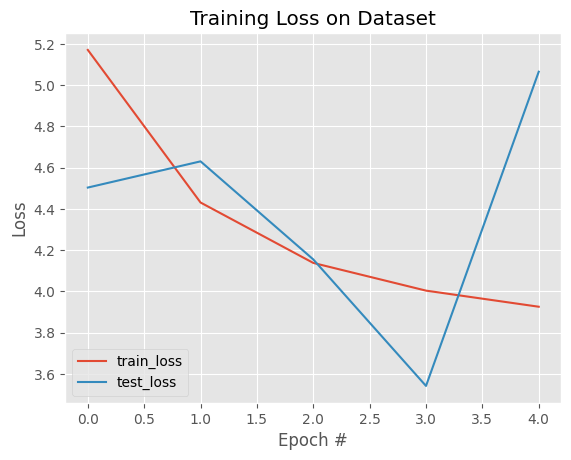

In [10]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

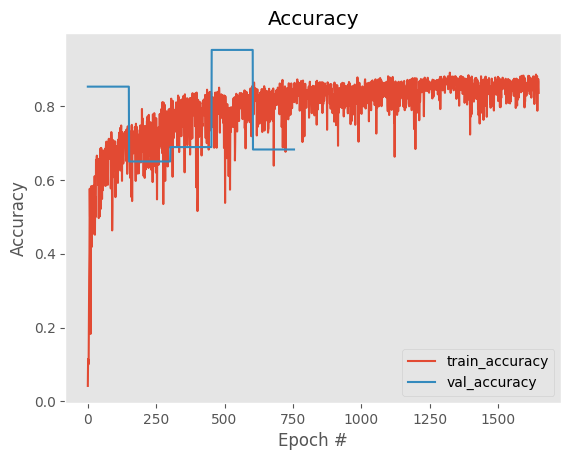

In [11]:
# Accuracy
plt.style.use("ggplot")
plt.figure()

train_accuracy = [x.cpu().numpy() for x in accuracy_dict["train"]]
val_accuracy = [x.cpu().numpy() for x in accuracy_dict["val"]]

plt.plot(train_accuracy, label="train_accuracy")
plt.plot(val_accuracy, label="val_accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid()
plt.show()

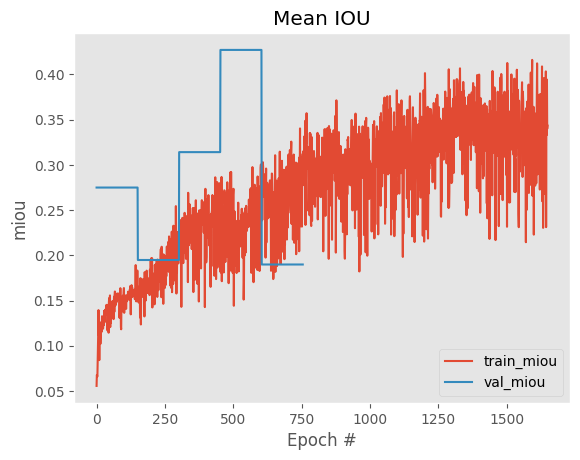

In [12]:
# Mean IoU
train_miou = [x.cpu().numpy() for x in miou_dict["train"]]
val_miou = [x.cpu().numpy() for x in miou_dict["val"]]

plt.plot(train_miou, label="train_miou")
plt.plot(val_miou, label="val_miou")
plt.title("Mean IOU")
plt.xlabel("Epoch #")
plt.ylabel("miou")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [44]:
# Mean IoU per class
train_miou = [x.cpu().numpy() for x in miou_per_class_dict["train"]]
val_miou = [x.cpu().numpy() for x in miou_per_class_dict["val"]]

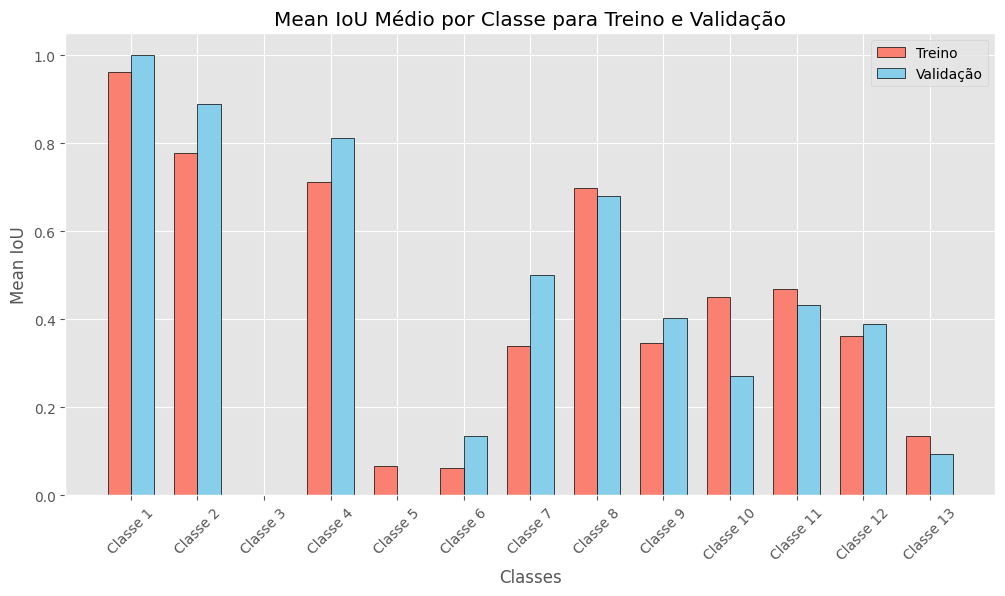

In [45]:
# Calcula a média do Mean IoU por classe para o conjunto de treino e validação
mean_train_miou = np.mean(train_miou, axis=0)
mean_val_miou = np.mean(val_miou, axis=0)

# Calcula a média do Mean IoU por classe para o conjunto de treino e validação
mean_train_miou = mean_train_miou[:13]
mean_val_miou = mean_val_miou[:13]

# Número de classes
num_classes = mean_train_miou.shape[0]
classes = [f'Classe {i+1}' for i in range(num_classes)]

# Plotando o gráfico de barras para Mean IoU de treino e validação
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(num_classes)

# Barras para treino e validação
plt.bar(index, mean_train_miou, bar_width, label='Treino', color='salmon', edgecolor='black')
plt.bar(index + bar_width, mean_val_miou, bar_width, label='Validação', color='skyblue', edgecolor='black')

# Configuração dos eixos e títulos
plt.xlabel('Classes')
plt.ylabel('Mean IoU')
plt.title('Mean IoU Médio por Classe para Treino e Validação')
plt.xticks(index + bar_width / 2, classes, rotation=45)
plt.legend()


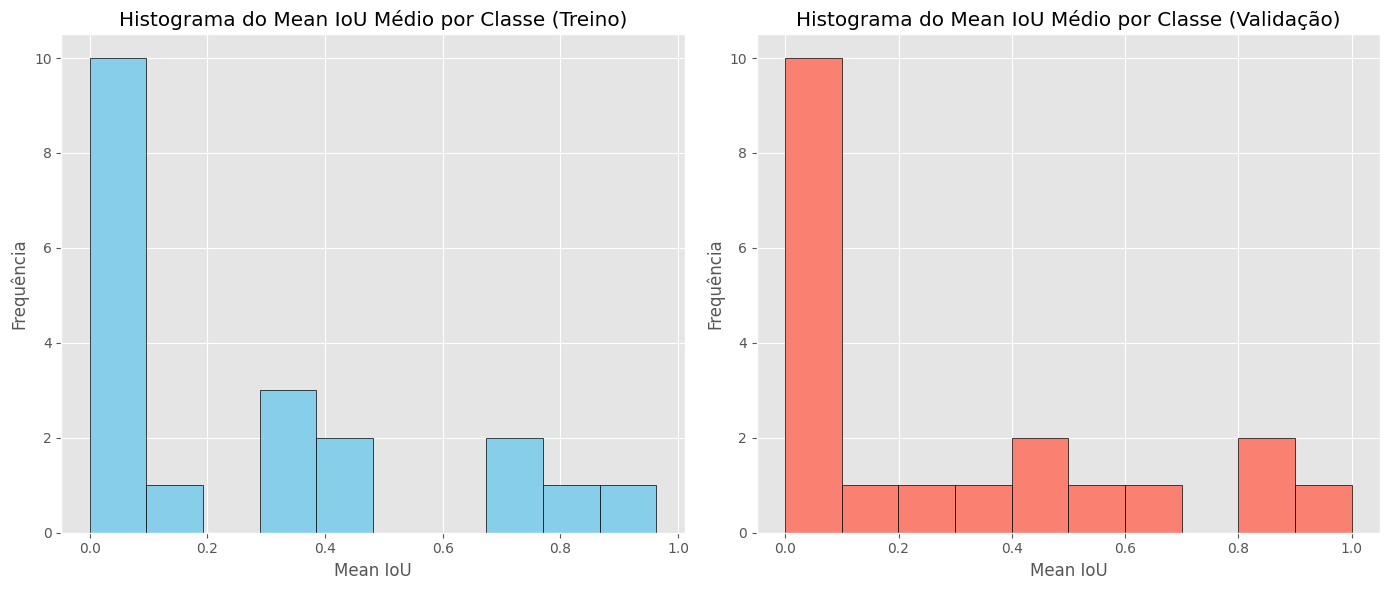

In [22]:
# Converte as listas de arrays para arrays 2D para cada variável
train_miou = np.array(train_miou)
val_miou = np.array(val_miou)

# Calcula a média do Mean IoU por classe para o conjunto de treino e validação
mean_train_miou = np.mean(train_miou, axis=0)
mean_val_miou = np.mean(val_miou, axis=0)

# Plotando os histogramas para os vetores médios de Mean IoU de treino e validação
plt.figure(figsize=(14, 6))

# Histograma do conjunto de treino
plt.subplot(1, 2, 1)
plt.hist(mean_train_miou, bins=10, color='skyblue', edgecolor='black')
plt.title('Histograma do Mean IoU Médio por Classe (Treino)')
plt.xlabel('Mean IoU')
plt.ylabel('Frequência')

# Histograma do conjunto de validação
plt.subplot(1, 2, 2)
plt.hist(mean_val_miou, bins=10, color='salmon', edgecolor='black')
plt.title('Histograma do Mean IoU Médio por Classe (Validação)')
plt.xlabel('Mean IoU')
plt.ylabel('Frequência')

# Ajusta o layout e exibe o gráfico
plt.tight_layout()
plt.show()


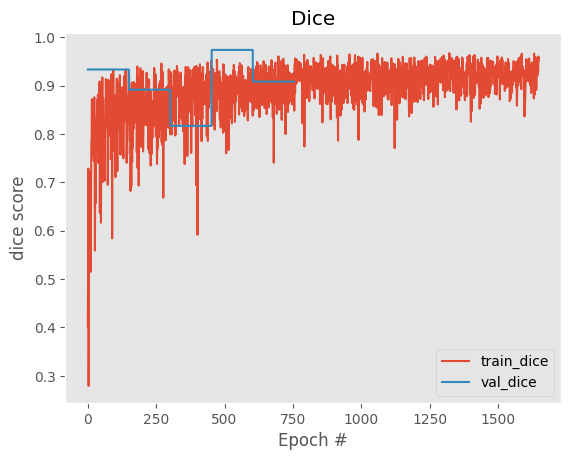

In [17]:
# Dice
train_dice = [x.cpu().numpy() for x in dice_dict["train"]]
val_dice = [x.cpu().numpy() for x in dice_dict["val"]]

plt.plot(train_dice, label="train_dice")
plt.plot(val_dice, label="val_dice")
plt.title("Dice")
plt.xlabel("Epoch #")
plt.ylabel("dice score")
plt.legend(loc="lower right")
plt.grid()
plt.show()

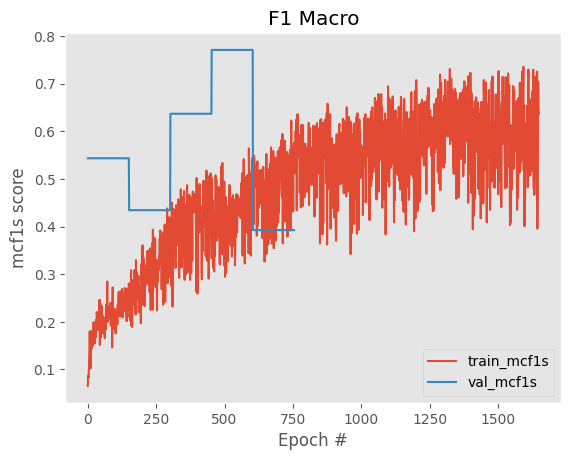

In [18]:
# F1 Macro
train_mcf1s = [x.cpu().numpy() for x in mcf1s_dict["train"]]
val_mcf1s = [x.cpu().numpy() for x in mcf1s_dict["val"]]

plt.plot(train_mcf1s, label="train_mcf1s")
plt.plot(val_mcf1s, label="val_mcf1s")
plt.title("F1 Macro")
plt.xlabel("Epoch #")
plt.ylabel("mcf1s score")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Vizualization

In [19]:
model = torch.load('ufgsim_transRVNet_torch.pt', weights_only=False).to(device)
model.eval()

TransVRNet(
  (mrciam): MRCIAM(
    (mrciam_depth): MRCIAMSingleChannel(
      (block1_3x3): ConvBNPReLU(
        (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=1)
      )
      (block1_5x5): ConvBNPReLU(
        (conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=1)
      )
      (block1_7x7): ConvBNPReLU(
        (conv): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (prelu): PReLU(num_parameters=1)
      )
      (block1_3x3_2): ConvBNPReLU(
        (conv): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05

In [20]:
pred = []
item = None
learning_map_inv_np = val_dataset.learning_map_inv_np
color_map_rgb_np = val_dataset.color_map_rgb_np

color_pred = None

channels=['x', 'y', 'z']
channels_map = {"x": 0, "y": 1, "z": 2, "d": 3}
num_channels = len(channels)
fig_size_vertical = 2*num_channels

for batch in val_loader:
    train_item = {key: value.to(device) for key, value in batch.items()}
    img, label, m = train_item['frame'], train_item['label'], train_item['mask']

    mask = m.cpu().squeeze(0).detach().numpy()
    item = train_item

    cpuimg = img.cpu()
    # Separate channels
    xyz = img[:, :3, :, :]
    depth = img[:, 3, :, :].unsqueeze(1)

    p = torch.argmax(model(depth, depth, xyz).cpu(), dim=1).squeeze(0).detach().numpy()

    print(mask.shape, mask.dtype)
    print(p.shape, p.dtype)
    print(learning_map_inv_np.shape)

    valid_indices = np.clip(p[mask], 0, len(learning_map_inv_np) - 1)
    p[mask] = learning_map_inv_np[valid_indices]
    colored_label_img = np.zeros(p.shape + (3,))
    colored_label_img[mask] = color_map_rgb_np[p[mask]]
    colored_label_img = colored_label_img.astype(int)

    color_pred = colored_label_img

    print(color_pred.shape)
    item['label'] = p
    # pred.append(torch.argmax(model(depth, depth, xyz).cpu().squeeze(0), dim=0))
    # plot_projections(cpuimg[0].data, color_pred, channels=['x'], channels_map=channels_map)
    break


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 1, 16, 440] to have 3 channels, but got 1 channels instead

In [ ]:
# plot_projections(cpuimg[0].data, color_pred, channels=['x'], channels_map=channels_map)